In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from sklearn.preprocessing import OneHotEncoder

In [5]:
def load_dataset(filename):
    #read data from csv file with 2 columns: one for question and other for intent
    df = pd.read_csv(filename, encoding="latin1", names=["question", "intent"])
    df = df.dropna()
    intent = df["intent"]
    questions = list(df["question"])
    return (intent, questions)

In [6]:
intent, question = load_dataset("augmented_data.csv")

In [7]:
unique_intent = [
    "ieee_github",
    "ieee_how_long",
    "gen_who_made",
    "ieee_domains",
    "ieee_be_part_who",
    "gen_human",
    "ieee_past_events",
    "ieee_sponsor",
    "gen_help",
    "ieee_projects",
    "gen_who_you",
    "ieee_what_does",
    "gen_hi",
    "ieee_collab",
    "gen_thanks",
    "ieee_other_college",
    "ieee_current_board",
    "ieee_other_linked",
    "ieee_social_media",
    "gen_query",
    "ieee_what",
    "gen_bot",
    "ieee_future_events",
    "ieee_further_contact",
    "gen_how_you",
    "ieee_techloop",
    "gen_bye",
]

In [8]:
def cleaning(question):
    words = []
    #clean the questions of all punctuations
    for word in question:
        clean = re.sub(r"[^a-z A-Z 0-9]", " ", word)
        clean = word_tokenize(clean)
        words.append([i.lower() for i in clean])

    return words

In [9]:
cleaned_words = cleaning(question)

In [10]:
def create_tokenizer(cleaned_words, filters='!"#$%&*+,-./:;<=>?@[\]^`{|}~'):
    #tokenize the cleaned words in questions upto word level 
    token = Tokenizer(filters=filters)
    token.fit_on_texts(cleaned_words)
    return token

In [11]:
def max_length(cleaned_words):
    #get the number of words in longest question
    return len(max(cleaned_words, key=len))

In [12]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

In [13]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [14]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [15]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [16]:
padded_doc = padding_doc(encoded_doc, max_length)

In [17]:
output_tokenizer = create_tokenizer(unique_intent)

In [19]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [20]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [21]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [22]:
output_one_hot = one_hot(encoded_output)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train, x_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.25)

In [26]:
print("Shape of train_X = %s and train_Y = %s" % (x_train.shape, y_train.shape))
print("Shape of val_X = %s and val_Y = %s" % (x_val.shape, y_val.shape))

Shape of train_X = (10788, 58) and train_Y = (10788, 27)
Shape of val_X = (3597, 58) and val_Y = (3597, 27)


In [27]:
model=Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
#model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation = "relu"))    
model.add(Dropout(0.5))
model.add(Dense(27, activation = "softmax"))

In [28]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [29]:
filename = 'ieee_faq_bot.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(x_train, y_train, epochs = 30, batch_size = 1, validation_data= (x_val, y_val), verbose=1,callbacks=[checkpoint])

Epoch 1/30
10788/10788 [==============================] - 238s 21ms/step - loss: 2.8104 - accuracy: 0.1689 - val_loss: 1.3629 - val_accuracy: 0.5657

Epoch 00001: val_loss improved from inf to 1.36286, saving model to ieee_faq_bot_1.h5
Epoch 2/30
10788/10788 [==============================] - 232s 22ms/step - loss: 1.3813 - accuracy: 0.5637 - val_loss: 0.8865 - val_accuracy: 0.743716 - ac

Epoch 00002: val_loss improved from 1.36286 to 0.88647, saving model to ieee_faq_bot_1.h5
Epoch 3/30
10788/10788 [==============================] - 221s 20ms/step - loss: 0.8347 - accuracy: 0.7484 - val_loss: 0.4881 - val_accuracy: 0.8463uracy: 0.74 - ETA: 46s - loss: 0.8384 - accuracy: 0.746 -  - ETA: 0s - loss: 0

Epoch 00003: val_loss improved from 0.88647 to 0.48812, saving model to ieee_faq_bot_1.h5
Epoch 4/30
10788/10788 [==============================] - 230s 21ms/step - loss: 0.5746 - accuracy: 0.8223 - val_loss: 0.4163 - val_accuracy: 0.8869

Epoch 00004: val_loss improved from 0.48812 to 0.

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 128)           376576    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1755      
Total params: 657,947
Trainable params: 281,371
Non-trainable params: 376,576
_________________________________________________________________


In [31]:
def plot_accuracy(history):
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['val_accuracy', 'Train_accuracy'], loc = 'lower right')
    plt.show()

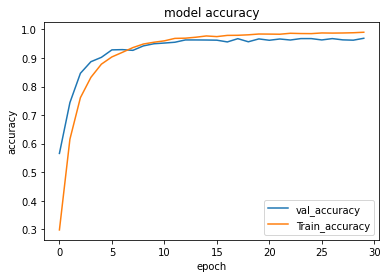

In [32]:
plot_accuracy(history)

In [33]:
def plot_loss(history):
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'train_loss'], loc = 'best')
    plt.show()

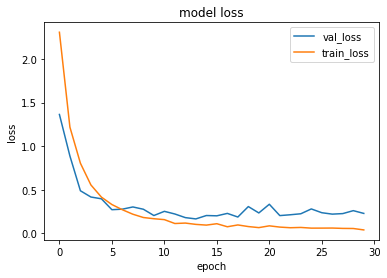

In [34]:
plot_loss(history)

In [35]:
_,acc=model.evaluate(x_val,y_val)
print(acc*100)

113/113 [==============================] - 2s 11ms/step - loss: 0.2284 - accuracy: 0.9689
96.88629508018494


In [23]:
#load the pre-trained model
loaded_model = load_model("ieee_faq_bot.h5")

In [24]:
res_time_initial=time.time()

In [25]:
def predictions(user_query):
    #clean and tokenize input user query
    clean_user_query = re.sub(r"[^ a-z A-Z 0-9]", " ", user_query)
    clean_user_query = word_tokenize(clean_user_query)
    clean_user_query = [w.lower() for w in clean_user_query]
    tokenized_user_query = word_tokenizer.texts_to_sequences(clean_user_query)

    #filter unknown words
    if [] in tokenized_user_query:
        tokenized_user_query = list(filter(None, tokenized_user_query))

    #reshape array as per our needs
    tokenized_user_query_len=len(tokenized_user_query)
    tokenized_user_query = np.array(tokenized_user_query).reshape(1, tokenized_user_query_len)
    ready_user_query = padding_doc(tokenized_user_query, max_length)

    #make prediction
    all_predictions = loaded_model.predict(ready_user_query)

    return all_predictions

In [26]:
def sort_predictions(all_predictions, classes):
    
    #as all_predictions is n dimentional array with shape (1,27)
    predictions = all_predictions[0]
    classes = np.array(classes)
    #use argsort to get sorted indices in dec order
    ids = np.argsort(-predictions)
    #sort classes as per sorted indices above
    classes = classes[ids]
    #sort predictions array in dec order
    predictions = -np.sort(-predictions)
    #get the intent with highest probability
    pred_intent = classes[0]

    return pred_intent

In [27]:
def ieee_faq_bot(user_query):
    #pass the user query through predictions function and get predicted intent
    all_predictions = predictions(user_query)
    predicted_intent = sort_predictions(all_predictions, unique_intent)

    return predicted_intent


In [28]:
ieee_faq_bot("hi")

'gen_hi'

In [29]:
time.time()-res_time_initial

6.811220645904541